In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint, ode
from scipy.special import roots_laguerre
import timeit

In [2]:
def rk4(odefunc,y0,t0,tf,dt,r,backwards=False):
    tv, p = [t0], [np.array(y0,dtype=float)]
    y, t = y0, t0
    Nt = int(np.fabs(tf-t0)/dt)+1
    if backwards:
        dt = -1*dt
        
    tic = timeit.default_timer()

    for tstep in range(Nt):
        k1 = dt*odefunc(t, y, r)
        k2 = dt*odefunc(t+dt/2, y+k1/2, r)
        k3 = dt*odefunc(t+dt/2, y+k2/2, r)
        k4 = dt*odefunc(t+dt, y+k3, r)
        y += (k1 + 2*k2 + 2*k3 + k4)/6
                
        t += dt
        p.append(np.array(y,dtype=float)) # speed & storage test
        tv.append(t)

    toc = timeit.default_timer()
    print('Run complete in {:4.2f} seconds.'.format(toc-tic))
    return tv, p

In [130]:
def ivp_solve(odefunc,y0,t0,tf,dt,r,backwards=False):
    tv, sol = [], []

    if backwards:
        dt = -1*dt
        f = ode(odefunc).set_integrator('lsoda',with_jacobian=True)
        f.set_initial_value(y0,tf).set_f_params(r)
        
        tic = timeit.default_timer()
        while f.successful() and f.t > t0:
            f.integrate(f.t+dt)
            sol.append(f.y)
            tv.append(f.t)
        toc = timeit.default_timer()
        print('Run complete in {:4.2f} seconds.'.format(toc-tic))

    return tv, sol

###### Solve the nonlinear system of equations
\begin{align}
\dot{k} &= k^\alpha - \left(\delta + n + x\right)k - c\\
\dot{c} &= c\left(\alpha k^{\alpha - 1} - \left(\delta + x\right) - \left(\rho + be^{-\gamma t}\right) \right)
\end{align}

with $k(0) = k_0 = 0.25k^\ast_0$.

In [4]:
def Fode(t,y,r):
    # System of Equations
    # order for r: alpha, delta, xt, n, rho, b, gamma
    alpha, delta, xt, n, rho, b, gamma = r[0], r[1], r[2], r[3], r[4], r[5], r[6]
    return np.array([y[0]**alpha-(delta+xt+n)*y[0]-y[1],
            y[1]*(alpha*y[0]**(alpha-1)-(delta+xt)-(rho+b*np.exp(-gamma*t)))])

In [124]:
def jac(t,y,r):
    # order for r: alpha, delta, xt, n, rho, b, gamma
    alpha, delta, xt, n, rho, b, gamma = r[0], r[1], r[2], r[3], r[4], r[5], r[6]
    return np.array([[alpha*y[0]**(alpha-1)-(delta+n+xt),-1],
            [y[1]*alpha*(alpha-1)*y[0]**(alpha-2),alpha*y[0]**(alpha-1)-(delta+xt)-(rtp+b*np.exp(-gamma*t))]])

In [5]:
def g(x,b,gamma):
    return np.exp(-b/gamma)*np.exp((b/gamma)*np.exp(-gamma*x))

In [6]:
alpha, delta, xt, n = 0.75, 0.05, 0.02, 0.01
rho, b, gamma = 0.02, 0.5, 0.5
#----------------------------------------------------------------
N = 100
x,w = roots_laguerre(N)
x /= (rho-n)
w /= (rho-n)
Omega = w.dot(g(x,b,gamma))
lam = 1/Omega+n
#----------------------------------------------------------------
# No Commitment
#----------------------------------------------------------------
kzed = (alpha/(delta + lam + xt))**(1/(1-alpha)) # No commitment
czed = kzed**alpha - (delta + n + xt)*kzed # No commitment
#----------------------------------------------------------------
# Full Commitment
#----------------------------------------------------------------
kinf = (alpha/(delta + rho + xt))**(1/(1-alpha)) # Commitment
cinf = kinf**alpha - (delta + n + xt)*kinf # Commitment
#----------------------------------------------------------------
# Equilibria under no-commitment
#----------------------------------------------------------------
eq = np.array([kzed,czed])
print('k* no commitment: {:4.4f}'.format(kzed))
print('c* no commitment: {:4.4f}'.format(czed))
print('k(0) = {:2.4f}'.format(0.25*kzed))
print('k* commitment: {:4.4f}'.format(kinf))
print('c* commitment: {:4.4f}'.format(cinf))
print('lambda = {:4.4f}'.format(lam))

k* no commitment: 2456.8795
c* no commitment: 152.4195
k(0) = 614.2199
k* commitment: 4822.5309
c* commitment: 192.9012
lambda = 0.0365


### Full Commitment Case

In [131]:
# Full Commitment
alpha, delta, n, xt = 0.75, 0.05, 0.01, 0.02
rho, b, gamma = 0.02, 0.5, 0.5
# order for r: alpha, delta, xt, n, rho, b, gamma
r = (alpha, delta, xt, n, rho, b, gamma)
# Set the starting conditions
k0 = 0.25*kzed
kstart = kinf

# Set the simulation paramters
t0, tf, dt = 0, 200, 2e-3
eps = 1e-4
tol, error, nits, MAXITS = 1e-8, 1, 1, 20
print('Iteration {:d}'.format(0))

cu = cinf
y0 = [kstart, cu]
btv, bp = ivp_solve(Fode,y0,t0,tf,dt,r,backwards=True)
ku = bp[-1][0]

cl = cinf-eps
y0 = [kstart, cl]
btv, bp = ivp_solve(Fode,y0,t0,tf,dt,r,backwards=True)
kl = bp[-1][0]

# Start the while loop
while error > tol and nits < MAXITS:
    print('Iteration {:d}'.format(nits))
    # Store c_n to be c_{n-1} in the next iteration
    
    fl = kl-k0
    fu = ku-k0
    
    tmp = cu
    # Store c_{n+1} using the secant method by overwriting c_n
    cu = cl - fl*(cu-cl)/(fu-fl)
    # Swap in c_{n-1}
    cl = tmp
    # Set new initial conditions and solve the IVP
    y0 = [kstart, cu]
    btv, bp = ivp_solve(Fode,y0,t0,tf,dt,r,backwards=True)
    ku = bp[-1][0]

    y0 = [kstart, cl]
    btv, bp = ivp_solve(Fode,y0,t0,tf,dt,r,backwards=True)
    kl = bp[-1][0]
    # Compute the error using the Cauchy-criterion for convergence
    error = np.fabs(cl-cu)
    # Evalute the function
    nits += 1

#(kl,cu),(kl,cl),(k0,c0)
cstart = (k0-kl)*(cu-cl)/(ku-kl)+cl
y0 = [kstart, cstart]
btv, bp = ivp_solve(Fode,y0,t0,tf,dt,r,backwards=True)

bprod = np.array(bp)[:,0]
bcons = np.array(bp)[:,1]
kinf0 = bprod[-1]
cinf0 = bcons[-1]
print('k_0 = {:2.7f}'.format(k0))
print('k(0) ~ {:2.7f}'.format(kinf0))
print('c(0) ~ {:2.7f}'.format(cinf0))

Iteration 0
Run complete in 1.21 seconds.
Run complete in 1.19 seconds.
Iteration 1
Run complete in 1.16 seconds.
Run complete in 1.15 seconds.
Iteration 2
Run complete in 1.22 seconds.
Run complete in 1.21 seconds.
Iteration 3
Run complete in 1.29 seconds.
Run complete in 1.25 seconds.
Iteration 4
Run complete in 1.39 seconds.
Run complete in 1.24 seconds.
Iteration 5
Run complete in 1.24 seconds.
Run complete in 1.25 seconds.
Iteration 6
Run complete in 1.19 seconds.
Run complete in 1.24 seconds.
Iteration 7
Run complete in 1.25 seconds.
Run complete in 1.31 seconds.
Iteration 8
Run complete in 1.17 seconds.
Run complete in 1.20 seconds.
Iteration 9
Run complete in 1.26 seconds.
Run complete in 1.28 seconds.
Run complete in 1.20 seconds.
k_0 = 614.2198780
k(0) ~ 614.2198780
c(0) ~ 77.3051275


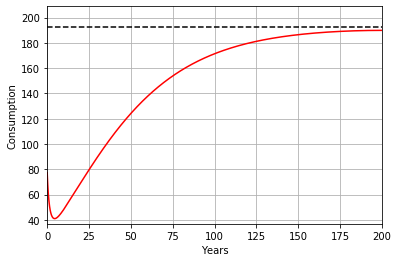

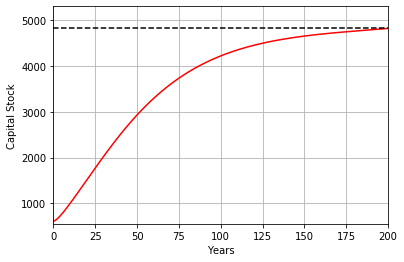

In [120]:
plt.figure()
plt.plot(btv,bcons,'r',[t0,tf],[cinf,cinf],'k--')
plt.xlabel('Years')
plt.ylabel('Consumption')
plt.grid(b=True)
plt.axis([t0,tf,np.min(bcons)*0.9,np.max(bcons)*1.1])

plt.figure()
plt.plot(btv,bprod,'r',[t0,tf],[kinf,kinf],'k--')
plt.xlabel('Years')
plt.ylabel('Capital Stock')
plt.grid(b=True)
plt.axis([t0,tf,np.min(bprod)*0.9,np.max(bprod)*1.1]);

### No Commitment Case

In [74]:
def dc(k,c,r):
    alpha, delta, xt, n, lam = r[0], r[1], r[2], r[3], r[4]
    return c*(alpha*k**(alpha-1)-(delta+xt)-lam)/(k**alpha-(delta+n+xt)*k-c)

In [79]:
# No commitment
alpha, delta, xt, n = 0.75, 0.05, 0.02, 0.01
# order for r: alpha, delta, xt, n, lam, b, gamma
r = (alpha, delta, xt, n, lam)
# Set the starting conditions
eps = 1e-4
k0 = 0.25*kzed
kstart, kfinish, cstart = kzed, k0, czed-eps

In [94]:
dk = -1e-2
f = ode(dc).set_integrator('lsoda')
f.set_initial_value(cstart,kstart).set_f_params(r)
kv, sol = [], []

while f.successful() and f.t > k0:
    f.integrate(f.t+dk)
    sol.append(f.y[0])
    kv.append(f.t)
c00 = sol[-1]
print('k_0 = {:2.7f}'.format(k0))
print('k(0) ~ {:2.7f}'.format(k0))
print('c(0) ~ {:2.7f}'.format(c00))

k_0 = 614.2198780
k(0) ~ 614.2198780
c(0) ~ 43.8919088


In [132]:
(cinf0-c00)/c00

0.7612614620531943